In [17]:
# %% ========================================
# 0. ライブラリ & データ読み込み
# ========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import timedelta
import os

# 前ノートブック（00）の出力ファイル
CLEAN_PATH = "/home/jovyan/work/data/interim/StatsAllGroup_cleaned.parquet"
df = pd.read_parquet(CLEAN_PATH)
print(f"✅ Loaded cleaned data: {df.shape[0]} rows, {df['athlete_name'].nunique()} athletes")


✅ Loaded cleaned data: 67994 rows, 69 athletes


In [18]:
# %% ========================================
# 1. 各選手のデータ期間サマリー作成
# ========================================
player_summary = (
    df.groupby("athlete_name")
      .agg(
          count=("date_", "count"),
          unique_days=("date_", lambda x: x.nunique()),
          first_date=("date_", "min"),
          last_date=("date_", "max")
      )
      .reset_index()
)
player_summary["duration_days"] = (player_summary["last_date"] - player_summary["first_date"]).dt.days + 1
player_summary["density_ratio"] = player_summary["unique_days"] / player_summary["duration_days"]

In [19]:
# %% ========================================
# 2. 3ヶ月45日基準による選手選別
# ========================================
window_days = 90
min_days_in_window = 45

valid_players = []
for athlete, sub in df.groupby("athlete_name"):
    dates = sub["date_"].drop_duplicates().sort_values()
    for start in dates:
        end = start + timedelta(days=window_days)
        if (dates.between(start, end).sum() >= min_days_in_window):
            valid_players.append(athlete)
            break

df_valid = df[df["athlete_name"].isin(valid_players)].copy()
player_summary["is_valid"] = player_summary["athlete_name"].isin(valid_players)

print(f"✅ 有効選手数: {len(valid_players)} / {df['athlete_name'].nunique()} 名")

✅ 有効選手数: 57 / 69 名


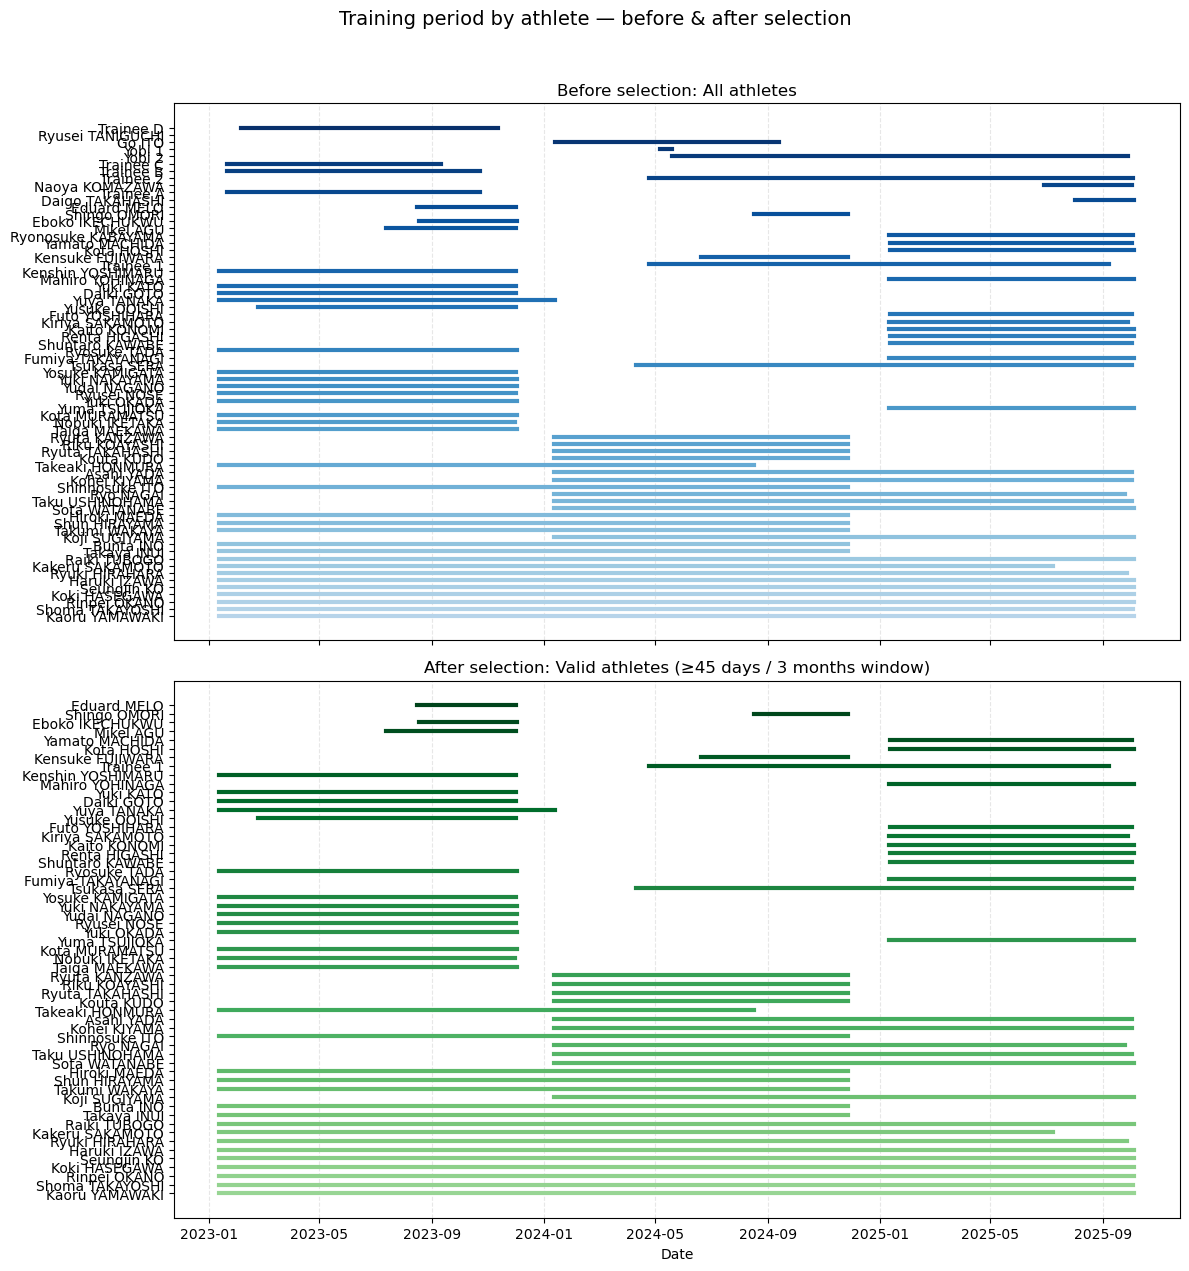

In [20]:
# %% ========================================
# 3. 可視化：選別前後の比較
# ========================================
player_summary_sorted = player_summary.sort_values("count", ascending=False).reset_index(drop=True)
colors_all = cm.Blues(np.linspace(0.3, 1, len(player_summary_sorted)))
valid_summary = player_summary_sorted[player_summary_sorted["is_valid"]].reset_index(drop=True)
colors_valid = cm.Greens(np.linspace(0.4, 1, len(valid_summary)))

fig, axes = plt.subplots(2, 1, figsize=(12, len(player_summary_sorted) * 0.18), sharex=True)
plt.subplots_adjust(hspace=0.3)

# 上段：全選手
ax1 = axes[0]
for i, row in player_summary_sorted.iterrows():
    ax1.plot([row["first_date"], row["last_date"]], [i, i], color=colors_all[i], linewidth=3)
ax1.set_yticks(range(len(player_summary_sorted)))
ax1.set_yticklabels(player_summary_sorted["athlete_name"])
ax1.set_title("Before selection: All athletes", fontsize=12)
ax1.grid(True, axis="x", linestyle="--", alpha=0.3)

# 下段：選別後選手
ax2 = axes[1]
for i, row in valid_summary.iterrows():
    ax2.plot([row["first_date"], row["last_date"]], [i, i], color=colors_valid[i], linewidth=3)
ax2.set_yticks(range(len(valid_summary)))
ax2.set_yticklabels(valid_summary["athlete_name"])
ax2.set_title("After selection: Valid athletes (≥45 days / 3 months window)", fontsize=12)
ax2.set_xlabel("Date")
ax2.grid(True, axis="x", linestyle="--", alpha=0.3)

fig.suptitle("Training period by athlete — before & after selection", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [21]:
# %% ========================================
# 4. 保存（次ノートブックで利用）
# ========================================
INTERIM_DIR = "/home/jovyan/work/data/interim"
PROCESSED_DIR = "/home/jovyan/work/data/processed"
os.makedirs(INTERIM_DIR, exist_ok=True)
os.makedirs(PROCESSED_DIR, exist_ok=True)

VALID_PATH = os.path.join(INTERIM_DIR, "df_valid.parquet")
SUMMARY_PATH = os.path.join(PROCESSED_DIR, "player_summary.csv")
VALID_CSV_PATH = os.path.join(PROCESSED_DIR, "valid_players.csv")

df_valid.to_parquet(VALID_PATH, index=False)
player_summary.to_csv(SUMMARY_PATH, index=False)
player_summary[player_summary["is_valid"]].to_csv(VALID_CSV_PATH, index=False)

print(f"💾 Saved valid dataset: {VALID_PATH}")
print(f"💾 Saved summaries: {SUMMARY_PATH}, {VALID_CSV_PATH}")
print("👉 次のノートブック（02_feature_engineering.ipynb）では df_valid.parquet を読み込みます。")

💾 Saved valid dataset: /home/jovyan/work/data/interim/df_valid.parquet
💾 Saved summaries: /home/jovyan/work/data/processed/player_summary.csv, /home/jovyan/work/data/processed/valid_players.csv
👉 次のノートブック（02_feature_engineering.ipynb）では df_valid.parquet を読み込みます。
